# 3.3.2. Batched training with contexts (tg.common.ml.batched_training.context)

This demo will cover training on data that are _contextual_. By that we mean cases, when some of the samples form relations, and to make a prediction about sample ***i***, the network must take into consideration all the samples, related to this sample ***i***.

The typical example is Natural Language Processing. Often, we cannot really do anything with an individual word in the sentence, we need to consider other words in its vicinity. Most often, ***N*** words to the left form this vicinity, but not only: if a parse tree of the sentence is available, we may consider "brothers" of the word, or parents, etc. 

Contextual data are also possible in sales. If we try to predict the customer-to-article relation, there are many assotiated contexts: previous purchases of the customer, other articles in the order, historical performance of the article, etc.

This demo will discuss ways of organizing the contexts in the various ways, including using of recurrent neural networks (LSTM)

## Setup

We will consider a toy task from NLP. Assume we have ***n*** words, and sentences of ***m*** such words. Some of these sentences belong to the "good" subset ***L***, and some don't. The task is to build a classifier for ***L***.

First, to establish the baseline, we will build the network without any contexts. For that, we will first build a training data as a dataframe with words in columns:

In [1]:
import numpy as np
import pandas as pd
import os

def generate_task(word_length, alphabet):
    tuples = [ (c,) for c in alphabet]
    result = list(tuples)
    for i in range(word_length-1):
        result = [ t+r for t in tuples for r in result]
    df = pd.DataFrame(result, columns=[f'word_{i}' for i in range(word_length)])
    df[f'label'] = np.random.randint(0,2,df.shape[0])
    df.index.name = 'sentence_id'
    df['split'] = 'display'
    return df

df = pd.read_parquet('lstm_task.parquet')
df.head()

,word_0,word_1,word_2,word_3,label,split
sentence_id,,,,,,
0,A,A,A,A,0,display
1,A,A,A,B,1,display
2,A,A,A,C,0,display
3,A,A,B,A,0,display
4,A,A,B,B,0,display


In [2]:
df.shape

(81, 6)

The following code will create a `BatchedTrainingTask` for this classification task, similarly to what we've seen in the previous demos. It will also output a batch for the task.

In [3]:
from tg.common.ml import dft
from tg.common.ml import batched_training as bt
from tg.common.ml.batched_training import torch as btt
from sklearn.metrics import roc_auc_score
from tg.common import Logger

Logger.disable()

def create_plain_task(df, epochs = 500):
    label_extractor = bt.PlainExtractor.build('label').index().apply(take_columns='label')
    features_extractor = bt.PlainExtractor.build('features').index().apply(
        take_columns=[f for f in df.columns if f.startswith('word')],
        transformer=dft.DataFrameTransformerFactory.default_factory()
    )
    extractor_factory = btt.PredefinedExtractorFactory(label_extractor, features_extractor)
    network_factory = btt.FullyConnectedNetwork.Factory(sizes=[100,1]).prepend_extraction('features')
    task = btt.TorchTrainingTask(
        bt.TrainingSettings(epoch_count = epochs),
        btt.TorchTrainingSettings(),
        extractor_factory,
        network_factory,
        bt.MetricPool().add_sklearn(roc_auc_score)
    )
    return task


plain_bundle = bt.DataBundle(index=df)
task = create_plain_task(df)
task.generate_sample_batch(plain_bundle)['features'].head()

,word_0_A,word_0_B,word_0_C,word_1_A,word_1_B,word_1_C,word_2_A,word_2_B,word_2_C,word_3_A,word_3_B,word_3_C
sentence_id,,,,,,,,,,,,
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


We won't have any test data. As ***L*** is random, it's impossible to predict the status of the word without seeing it. So effectively, the neural network just needs to memorize the table. 
  

The following code will run the training task on the data multiple times and build a plot of `roc_auc` metric improvement over time for each of them:

  0%|          | 0/5 [00:00<?, ?it/s]

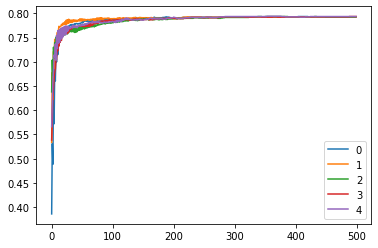

In [4]:
from yo_fluq_ds import *

def get_roc_auc_curve(name, task, bundle):
    result = task.run(bundle)
    series = pd.DataFrame(result['output']['history']).roc_auc_score_display
    series.name = str(name)
    return series

curves = (Query
          .en(range(5))
          .feed(fluq.with_progress_bar())
          .select(lambda z: get_roc_auc_curve(z, create_plain_task(df, epochs=500), bt.DataBundle(index=df)))
          .to_list()
         )
pd.DataFrame(curves).transpose().plot()
pass

Note that:

* Training effectively stabilizes on ~200 iterations. We were unable to achieve significant improvement after this point.
* The quality is far from 100%. The amount of neurons in the network are compatible with the amount of samples, and, given that the samples are random, it's not surprising. 

It is probably possible to achieve higher metric on this task, but right now it's not our goal. 

The quality depends heavily on the training data: some of the random languages $L$ offer better performance than others. The following code was used to find a language with decent performance:


In [5]:
def find_good_language(N):
    tasks = []
    rocs = []
    for i in Query.en(range(N)).feed(fluq.with_progress_bar()):
        df = generate_task(4, ['A','B','C'])
        tasks.append(df)
        roc = get_roc_auc_curve(i, create_plain_task(df), bt.DataBundle(df, {}))
        value = roc.iloc[-1]
        rocs.append(value)
        print(value, end=' ')
    
    s = pd.Series(rocs).sort_values()
    winner = s.index[-1]
    val = s.iloc[-1]
    tasks[winner].to_parquet(f'lstm_task_{val}.parquet')
    return s

## Contexts

The representation we used in the previous section is flawed due to several reasons:

* Sequential data usually have different length. Placing them in the columns of the dataframe causes sparsity. 
* Sequential data may contain multiple columns for each position, i.e. morphological features or word2vec for words. Placing them in the columns of the dataframe creates a hierarchy of the columns.
* Pandas is not really covenient to perform column-based operations, that will mean loops and other low-performative python logic.
* Samples may enter in more than one relations, and it's unpractical to build such table for each of them.

This is why it's far more convenient to use a sequential representation: each row is a sample (word in our case), but there is also a structural information, incorporated in the bundle, that represents relation of the samples. 

Let's translate our language ***L*** to this new format:

In [6]:
def translate_to_sequential(df):
    words = [c for c in df.columns if c.startswith('word_')]
    context_length = len(words)

    cdf = df[words].unstack().to_frame('word').reset_index()
    cdf = cdf.rename(columns=dict(level_0= 'word_position'))
    cdf.word_position = cdf.word_position.str.replace('word_','').astype(int)
    cdf = cdf.sort_values(['sentence_id','word_position'])
    cdf['word_id'] = list(range(cdf.shape[0]))
    cdf = cdf[['word_id','sentence_id','word_position','word']]
    cdf.index = list(cdf['word_id'])
    
    idf = df[['label']].reset_index()
    idf['split'] = 'display'
    idf.index.name='sample_id'
    bundle = bt.DataBundle(index = idf, src=cdf)
    bundle.additional_information.context_length = context_length
    return bundle

db = translate_to_sequential(df)

`src` frame contains all word in the sentences;

In [7]:
db.src.head()

,word_id,sentence_id,word_position,word
0,0,0,0,A
1,1,0,1,A
2,2,0,2,A
3,3,0,3,A
4,4,1,0,A


This structure is what we currently think the best approach for NLP:

* `word_id` is a unique, always-increasing `id` of the occurence of the word in the text
* `sentence_id` is a unique, always-increasing `id` of the word/sentence.
* `word_position` additionally positions words within sentences
* Additional indexations (like `paragraph_id`, `sentence_position`, etc) are possible.


In [8]:
db.index.head()

,sentence_id,label,split
sample_id,,,
0,0,0,display
1,1,1,display
2,2,0,display
3,3,0,display
4,4,0,display


**Note**: indexation might appear excessive. We just follow the practice from other NLP tasks: there, not all the sentences in the corpus may appear in `index_frame`; as for `src`, in some cases it's handy to have `word_id` as a column, and in other cases -- as index, therefore, index of `src` simply duplicates the `word_id` column.

Now, our task is to build back the features for each sentence, by taking all the previous words in this sentence, transforming them in the features individually and then combining. This procedure is done by four entities, three basic are:
* `ContextBuilder` builds the context, i.e. relation from one instance of `index` entity to several other entities (not necessarily from `index`). 
* `Extactor` extracts features for each sample in the context.
* `Aggregator` then organizes the features so they are in the format, consumable by the network (2D dataframe)

There might be multiple extractors and aggregators for each context. Therefore, we add `Finalizer`, that concatenates aggregator's results, and also controls shape of the resulting dataframe, e.g. that even the samples with empty context receive their row in the features, and that all the columns are in their exact place.

Let's first cover the `ContextBuilder`:

In [9]:
from tg.common.ml.batched_training import context as btc

class SentenceContextBuilder(btc.ContextBuilder):
    def build_context(self, ibundle, context_size):
        df = ibundle.index_frame[['sentence_id']]
        df = df.merge(ibundle.bundle.src.set_index('sentence_id'), left_on='sentence_id', right_index=True)
        df = df[['word_position','word_id','word']]
        df = df.loc[df.word_position<context_size]
        df = df.set_index('word_position', append=True)
        return df

ibundle = bt.IndexedDataBundle(db.index, db)
ibundle_sample = ibundle.change_index(ibundle.index_frame.iloc[:3])
context_builder = SentenceContextBuilder()
context_builder.fit(ibundle)
context_builder.build_context(ibundle_sample, 4)

word_id word
sample_id word_position              
0         0                    0    A
          1                    1    A
          2                    2    A
          3                    3    A
1         0                    4    A
          1                    5    A
          2                    6    A
          3                    7    B
2         0                    8    A
          1                    9    A
          2                   10    A
          3                   11    C

As promised, it builds a relation from each `sample` to several rows in `src`, by different offsets. 

Now, we can use normal `Exctractor` to extract features. 

Also, we will use aggregator that simply concatenates the features for different samples in context, and `PandasFinalizer`, which should be always for every context extraction in 2D format. 

In [10]:
def build_context_extractor(context_length, aggregator):
    context_extractor = btc.ContextExtractor(
        name = 'features',
        context_size = context_length,
        context_builder = SentenceContextBuilder(),
        feature_extractor_factory = btc.SimpleExtractorToAggregatorFactory(
            bt.PlainExtractor.build('word').index().apply(
                take_columns=['word'], 
                transformer = dft.DataFrameTransformerFactory.default_factory()
            ),
            aggregator
        ),
        finalizer = btc.PandasAggregationFinalizer(
            add_presence_columns=False
        ),
        debug = True
    )
    return context_extractor

context_extractor = build_context_extractor(
    db.additional_information.context_length,
    btc.PivotAggregator()
)
context_extractor.fit(ibundle)
context_extractor.extract(ibundle_sample)

,f0a0_word_A_at_0,f0a0_word_A_at_1,f0a0_word_A_at_2,f0a0_word_A_at_3,f0a0_word_B_at_0,f0a0_word_B_at_1,f0a0_word_B_at_2,f0a0_word_B_at_3,f0a0_word_C_at_0,f0a0_word_C_at_1,f0a0_word_C_at_2,f0a0_word_C_at_3
sample_id,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Note that it looks exactly as a batch in the very first section. But this time the dataframe is assembled by the components from `tg.common.ml.batched_training.context`, and it's shape and nature can be altered by changing these components, thus enabling different architectures for the networks (including the recurrent ones)

`ContextExtractor` performs non-trivial functionality, and stepwise debugging may be needed. For this, `debug` argument can be used, exactly as it was the case with `BatchedTrainingTask` (and it also should be **always off** in production due to the same reasons)

We can explore intermediate stages within `ContextExtractors`, e.g. the output of the `Extractor`:

In [11]:
context_extractor.data_.feature_dfs['f0'].head()

word_A  word_B  word_C
sample_id word_position                        
0         0                 1.0     0.0     0.0
          1                 1.0     0.0     0.0
          2                 1.0     0.0     0.0
          3                 1.0     0.0     0.0
1         0                 1.0     0.0     0.0

Now, we will assemble the neural network to train on this data. 

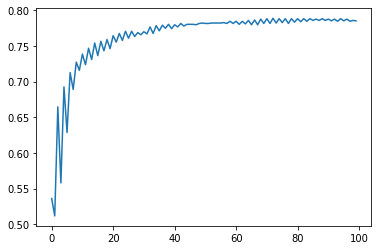

In [12]:
def create_sequential_task(context_extractor, network_factory, lr = 1, epochs = 100):
    task = btt.TorchTrainingTask(
        bt.TrainingSettings(epoch_count=epochs),
        btt.TorchTrainingSettings(
            optimizer_ctor=btt.OptimizerConstructor('torch.optim:SGD', lr=lr)
        ),
        btt.PredefinedExtractorFactory(
            context_extractor,
            bt.PlainExtractor.build('label').index().apply(take_columns='label')
        ),
        network_factory,
        bt.MetricPool().add_sklearn(roc_auc_score)
    )
    return task

task = create_sequential_task(
    build_context_extractor(
        db.additional_information.context_length,
        btc.PivotAggregator()
    ),
    btt.FullyConnectedNetwork.Factory([100,1]).prepend_extraction(['features'])
)
    
get_roc_auc_curve('', task, db).plot()
pass

So, the system achieved the same performance at the same time, as a naive implementation, confirming the correctness of the implementation (of course, the used classes are also covered by tests).

Let's now explore the task a bit further and see how the context length affects the performance:

  0%|          | 0/4 [00:00<?, ?it/s]

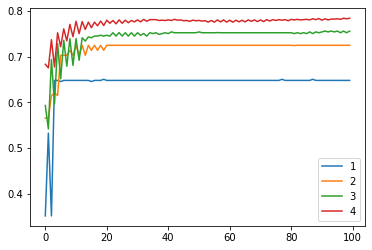

In [13]:
curves = []
for i in Query.en(range(1,db.additional_information.context_length+1)).feed(fluq.with_progress_bar()):
    task = create_sequential_task(
        build_context_extractor(i, btc.PivotAggregator()),
        btt.FullyConnectedNetwork.Factory([100,1]).prepend_extraction(['features'])
    )
    curves.append(get_roc_auc_curve(i, task, db))
pd.DataFrame(curves).transpose().plot()
pass

Unsurprisingly, we see that if the context is smaller that the actual length of the sentences in our langauge $L$, the performance decreases.

`PivotAggregator` is the most memory-consuming way of representing the contextual data. In this example it's fine, but if context consists of dozens of samples, each having dozens of extracted columns, `PivotAggregator` will produce a very huge matrix that may overfill the memory. 

This is why you may also want to use other aggregators. For instance, `GroupByAggregator` will process the `features` dataframe with grouping by `sample_id` and applying the aggregating functions:

In [14]:
context_extractor = build_context_extractor(i, btc.GroupByAggregator(['mean','max']))
task = create_sequential_task(
    context_extractor,
    btt.FullyConnectedNetwork.Factory([100,1]).prepend_extraction('features')
)
batch = task.generate_sample_batch(db)
Query.en(context_extractor.data_.agg_dfs.values()).first().head()

,word_A_mean,word_A_max,word_B_mean,word_B_max,word_C_mean,word_C_max
sample_id,,,,,,
0,1.00,1.0,0.00,0.0,0.00,0.0
1,0.75,1.0,0.25,1.0,0.00,0.0
2,0.75,1.0,0.00,0.0,0.25,1.0
3,0.75,1.0,0.25,1.0,0.00,0.0
4,0.50,1.0,0.50,1.0,0.00,0.0


Let's evaluate performance of this system as well

  0%|          | 0/4 [00:00<?, ?it/s]

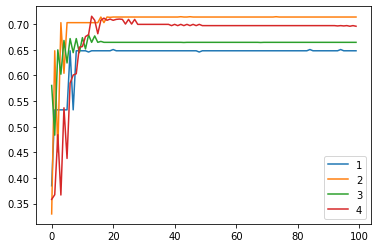

In [15]:
curves = []
for i in Query.en(range(1,db.additional_information.context_length+1)).feed(fluq.with_progress_bar()):
    task = create_sequential_task(
        build_context_extractor(i, btc.GroupByAggregator(['mean', 'max'])),
        btt.FullyConnectedNetwork.Factory([100,1]).prepend_extraction('features')
    )
    curves.append(get_roc_auc_curve(i, task, db))
pd.DataFrame(curves).transpose().plot()
pass

Of course, it does not work well, because we effectively destroy the information about the order of the letter in the word. 

But maybe we can invent some custom aggregator, which averages elements of the context with different weights, so the information is somehow preserved:

In [16]:
class CustomAggregator(btc.ContextAggregator):
    def aggregate_context(self, features_df):
        names = features_df.index.names
        if names[0] is None:
            raise ValueError('There is `None` in the features df index. This aggregator requires you to set the name for index of your samples')
        columns = features_df.columns
        df = features_df.reset_index()
        for c in columns:
            df[c] = df[c]/(df[names[1]]+1)
        df = df.groupby(names[0])[columns].mean()
        return df
    
context_extractor = build_context_extractor(i, CustomAggregator())
task = create_sequential_task(
    context_extractor,
    btt.FullyConnectedNetwork.Factory([100,1]).prepend_extraction('features')
)
batch = task.generate_sample_batch(db)
Query.en(context_extractor.data_.agg_dfs.values()).first().head()

,word_A,word_B,word_C
sample_id,,,
0,0.520833,0.000000,0.0000
1,0.458333,0.062500,0.0000
2,0.458333,0.000000,0.0625
3,0.437500,0.083333,0.0000
4,0.375000,0.145833,0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

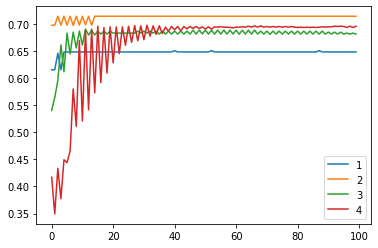

In [17]:
curves = []
for i in Query.en(range(1,db.additional_information.context_length+1)).feed(fluq.with_progress_bar()):
    task = create_sequential_task(
        build_context_extractor(i, CustomAggregator()),
        btt.FullyConnectedNetwork.Factory([100,1]).prepend_extraction('features')
    )
    curves.append(get_roc_auc_curve(i, task, db))
pd.DataFrame(curves).transpose().plot()
pass

Well, sounded good, didn't work.

## Caching contextual features

In some cases, contextual features are very large. If we had context length of 10 and 10 letters, we would have 100-fold increase of the size for index in the intermediate tables. This might overfill the memory, and this is why we compute the contextual features for the batch instead of the whole index.

However, that might bring the performance issues, as the contextual features are computed repeatedly, in each epoch. 

To offer a balance for that, we offer `PrecomputingExtractor`. This is a decorator that runs an arbitrary extractor in the beginning of the training, fits it, computes the features for the whole index and stores in the bundle.

In [18]:
import copy 

context_extractor = build_context_extractor(i, btc.GroupByAggregator(['mean','max']))
precompuring_extractor = bt.PrecomputingExtractor(
    name = "precomputed_features",
    inner_extractor = context_extractor)
ibundle_test = copy.deepcopy(ibundle)
precompuring_extractor.fit(ibundle)
ibundle.bundle.precomputed_features.head()

,f0a0_word_A_mean,f0a0_word_A_max,f0a0_word_B_mean,f0a0_word_B_max,f0a0_word_C_mean,f0a0_word_C_max
sample_id,,,,,,
0,1.00,1.0,0.00,0.0,0.00,0.0
1,0.75,1.0,0.25,1.0,0.00,0.0
2,0.75,1.0,0.00,0.0,0.25,1.0
3,0.75,1.0,0.25,1.0,0.00,0.0
4,0.50,1.0,0.50,1.0,0.00,0.0


As we see, the features were precomputed and added in `fit` method, which is called once before all the training start. The implementation will work for `BatchedTrainingTask.predict` method, as `PrecomputingExtractor`, when fitted, computes features in `preprocess_bundle` method, called by `predict`.

## LSTM

LSTM network, and, generally, recurrent neural networks are designed specifically for the tasks with context. So it's natural to try them for our tasks.

These networks, however, require 3-dimensional tensor as an input. So, we will need to modify the `ContextExtractor` in the following way:

In [19]:
def build_lstm_extractor(context_length):
    context_extractor = btc.ContextExtractor(
        name = 'features',
        context_size = context_length,
        context_builder = SentenceContextBuilder(),
        feature_extractor_factory = btc.SimpleExtractorToAggregatorFactory(
            bt.PlainExtractor.build('word').index().apply(
                take_columns=['word'], 
                transformer = dft.DataFrameTransformerFactory.default_factory()
            )),
        finalizer = btt.LSTMFinalizer()
    )
    return context_extractor

lstm_extractor = build_lstm_extractor(ibundle.bundle.additional_information.context_length)
lstm_extractor.fit(ibundle)
value = lstm_extractor.extract(ibundle_sample)

Here, we 

* don't use the aggregator. Aggregators are converting the context with features into 2-dimensional structure, which is exactly what we want to avoid.
* use `LSTMFinalizer` instead of `PandasFinalizer`

`LSTMFinalizer` looks at the feature table and converts it into tensor with the right dimensions:

In [20]:
value.tensor

tensor([[[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])

In [21]:
value.dim_names

['word_position', 'sample_id', 'features']

In [22]:
value.dim_indices

[[0, 1, 2, 3], [0, 1, 2], ['word_A', 'word_B', 'word_C']]

Now, we can train a neural network with `LSTMNetwork` component, which is a slim decorator over `LSTM` that manages it's output.

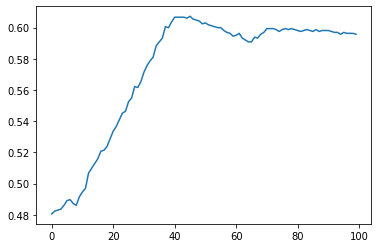

In [23]:
def build_lstm_network_factory(lstm_size):
    return btt.FeedForwardNetwork.Factory(
        btt.ExtractingNetwork.Factory('features'),
        btt.LSTMNetwork.Factory(lstm_size),
        btt.FullyConnectedNetwork.Factory([1])
    )


task = create_sequential_task(
    build_lstm_extractor(db.additional_information.context_length),
    build_lstm_network_factory(10),
    epochs = 100,
)

get_roc_auc_curve('', task, db).plot()
pass

We see that after 100 iterations the quality is low, but growing, while previous systems have stabilized at this point. So, we will train this network for a longer time.

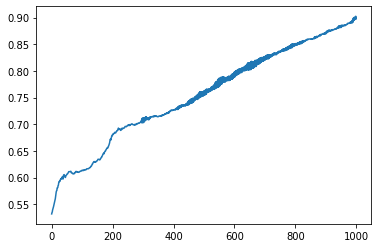

In [24]:
task = create_sequential_task(
    build_lstm_extractor(db.additional_information.context_length),
    build_lstm_network_factory(10),
    epochs = 1000
)

get_roc_auc_curve('', task, db).plot()
pass

In all the cases we run this cell, the quality of the "plain" networks was surpassed, often reaching the 0.9 value without stabilization. It might be the sign that this network architecture is indeed superior in comparison with the other, but this is anyway not the point we're trying to make. The point is that the classes, used for the data transformation, are working correctly and are ready to be used in conjustion with LSTM and other recurrent neural networks.